In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Sequential Data  
> 수치 데이터, 자연어 등 
  
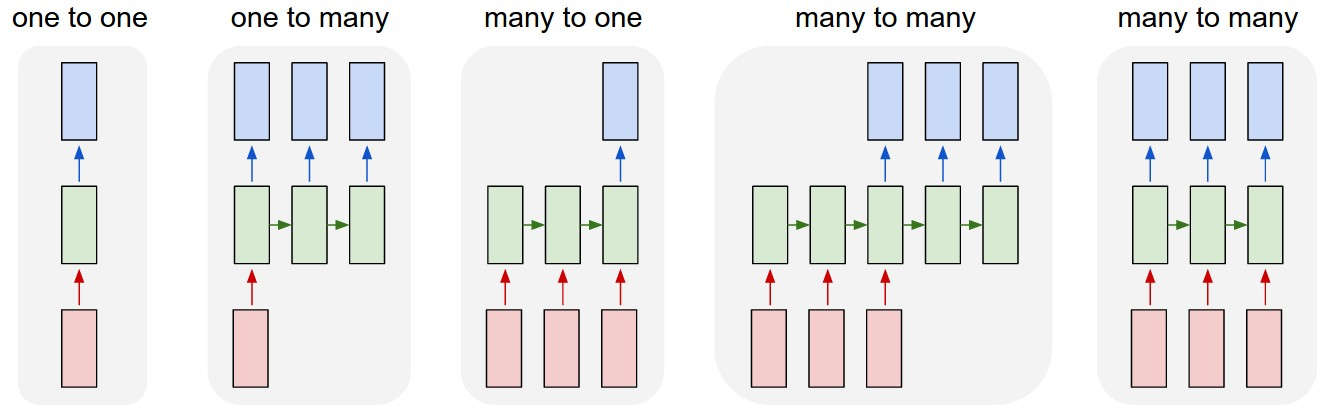
* one to one
* one to many : ex. 이미지 캡셔닝  
* many to one : ex. 감성분석
* many to many : ex. 번역, 품사분류


# RNN  
### RNN 구조 : 순환 구조를 이루고 있는 인공신경망
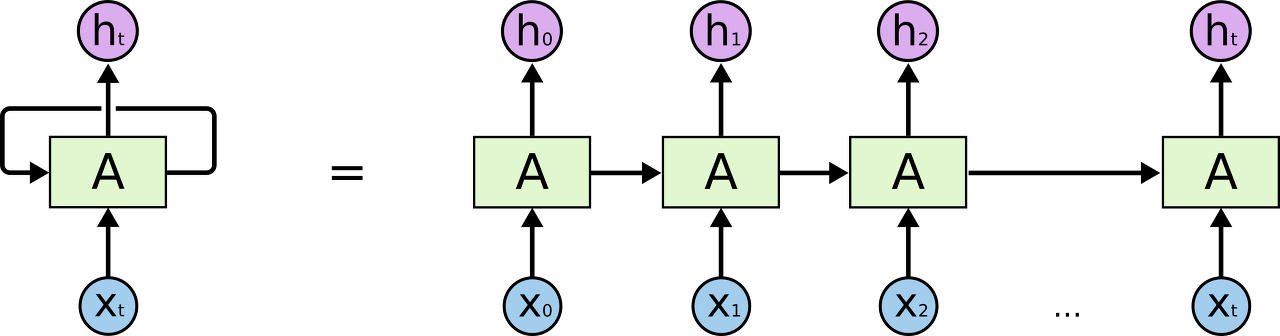

* 체인처럼 이어지는 구조 -> sequential한 데이터를 다루기에 최적화된 구조의 neural network  
* hidden state를 만들기 위해 현재 state의 input과 이전 state의 output을 사용  
* $h_{t} = f(Ux_{t} + Wh_{t-1})$  
* $y_{t} = f(Vh_{t})$

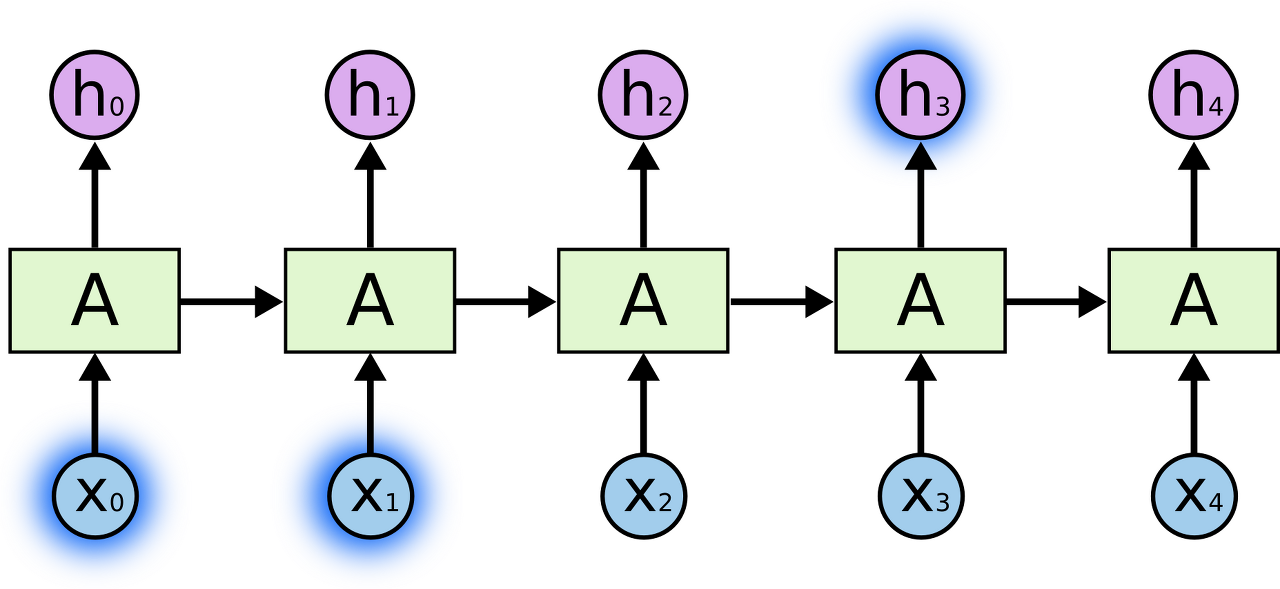

#### "나는 어린 시절 프랑스에서 자랐다. 그래서 나는 ?가 유창하다."

* 위 문장에서 ?에 들어가기 적합한 단어는 <프랑스어> 일 것입니다.
* <프랑스어> 라는 단어를 단어를 유추해야할 때 단서로 사용할 수 있는 단어는 아마도 <프랑스>일 것이다.  
* 긴 문장에서 다음에 등장할 특정 단어를 유추해야할 때 필요한 것은 **문맥**이다. 
* 이처럼 대부분의 시퀀스 데이터에서 각 요소들은 시간 차를 두고 관련성을 가지고 있다.
* 관련된 요소가 멀리 떨어져 있는 경우 시퀀스에 **장기 의존성 (long term dependency)**가 존재한다고 얘기할 수 있는데, 이는 input sequence가 길수록 발생하기 쉽다.
* 이 때 발생하는 문제점으로는 **Vanishing gradient** 또는 **Exploding gradient** 가 있다.

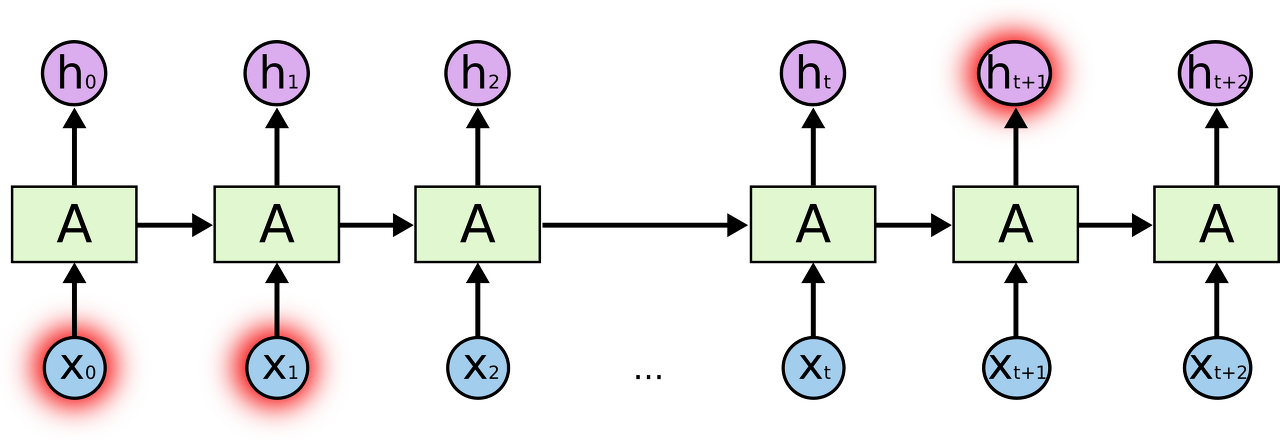

#### Vanishing Gradient  
* $h_{t-2} = tanh(W[h_{t-3}, x_{t-2}])$  
* $h_{t-1} = tanh(W[h_{t-2}, x_{t-1}])$  
* $h_{t} = tanh(W[h_{t-1}, x_{t}])$  

> $h_{t} = tanh(W[tanh(..tanh(h_{t-3}), x_{t}])$  
  
* hidden state에 연산이 계속적으로 쌓이고 쌓이므로 값이 0에 가까워진다 -> 소멸  
* 특히 시퀀스의 앞부분 요소의 영향력은 타임스탬프가 진행될수록 소멸할 가능성이 높다 (이론상으로는 정보가 누적저장된다고 하지만 1보다 작은 weight를 계속해서 반복적으로 곱하면 지수적으로 감소)  
  
그래서 등장한 모델이 LSTM

# LSTM  
### 일반 RNN  
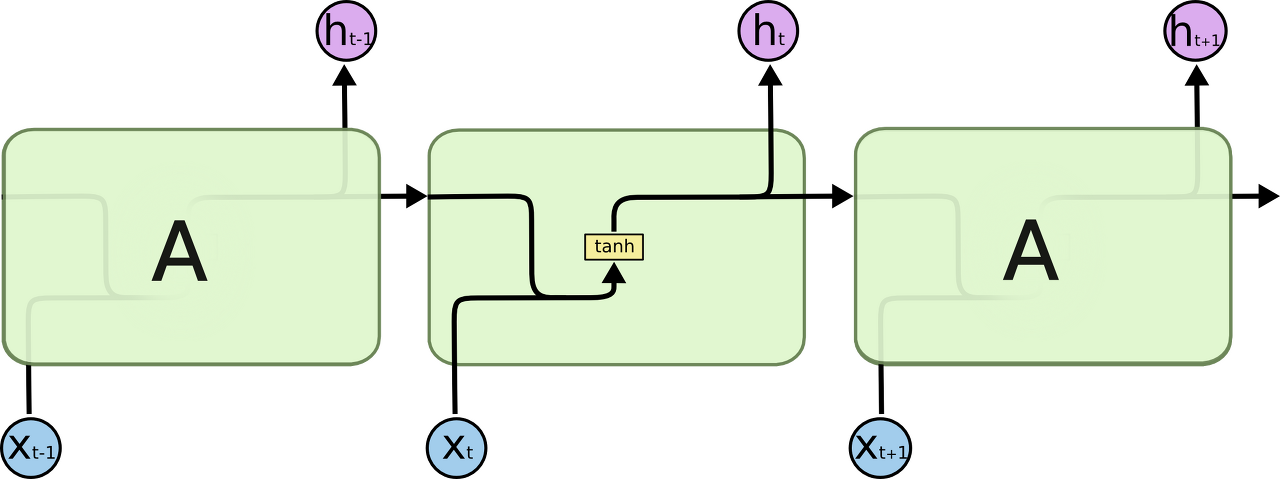

### LSTM  
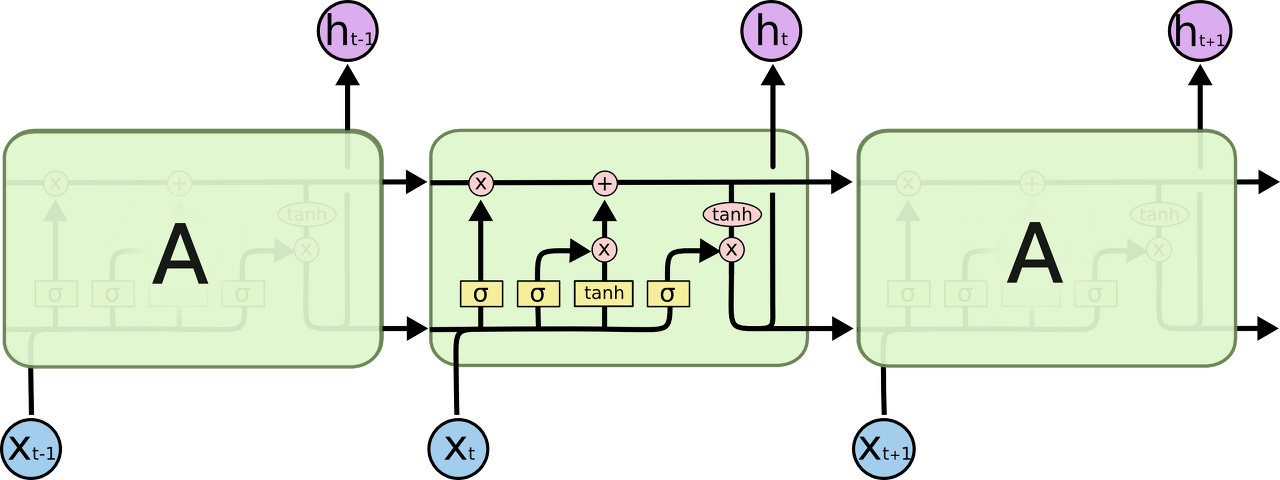

#### Step1. 어떤 정보를 버릴 것인가 (forget gate layer)  
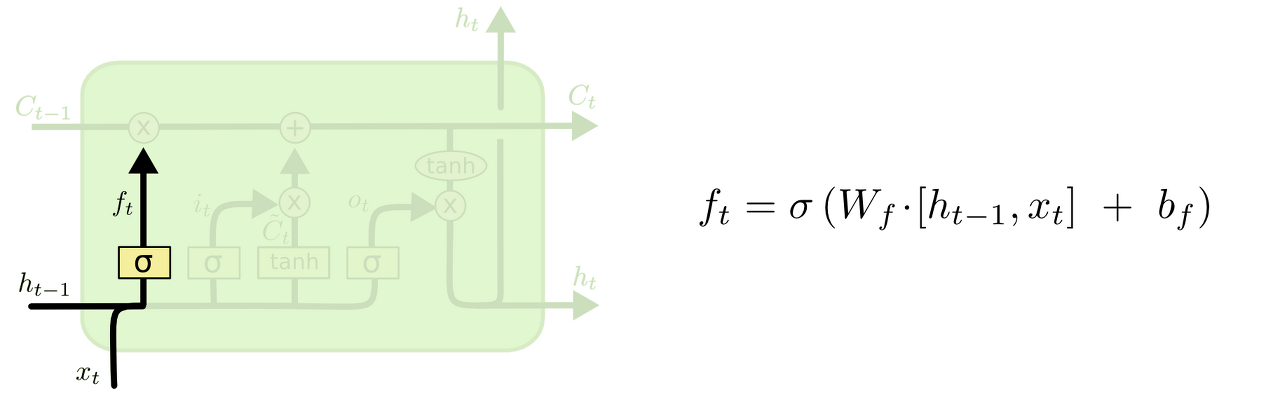

* cell state로 부터 어떤 정보를 버릴 것인지 sigmoid layer를 통해 결정  
* $h_{t-1}, x_{t}$ 를 받아서 [0, 1] 사이의 값을 $C_{t-1}$에 내보냄 
* 1 : 모든 정보를 보존해라
* 0 : 모든 정보를 버려라

### Step2. 어떤 정보를 저장할 것인가 (input gate layer)  
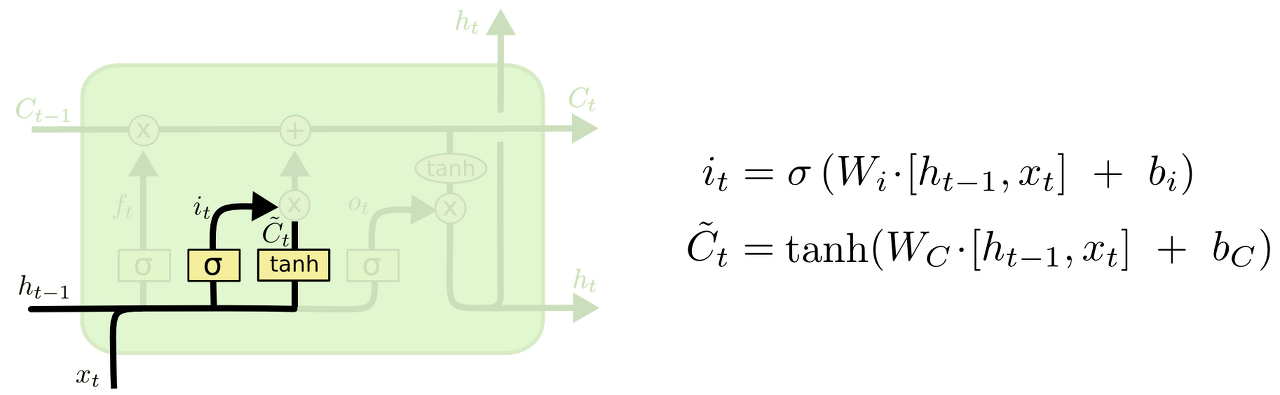

* 또 다른 sigmoid layer가 어떤 값을 업데이트할지 결정
* tanh layer가 새로운 후보값들인 $C^{~}_{t}$ 라는 벡터를 생성
* 두 단계에서 나온 정보를 합쳐서 state를 업데이트할 재료를 생성

### Step3. 무엇을 output으로 내보낼 것인가 (cell state 업데이트)
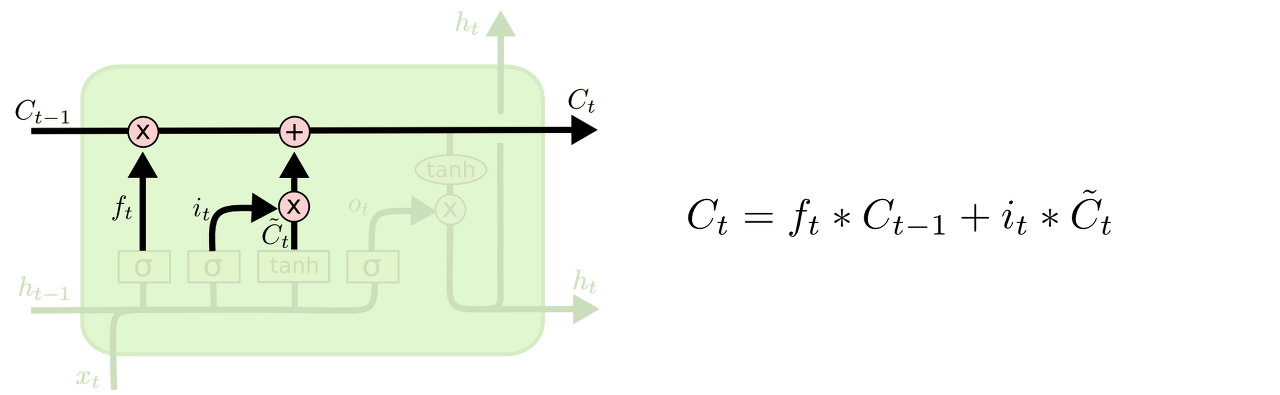

* 과거 cell state * forget layer output + input gate layer를 최종 output으로 보냄

# 실습  

In [ ]:
class data_simulation(): # parameter : beta, sig, phi
    def __init__(self, nYear, nsim, parameter):
        self.nYear = nYear
        self.nsim = nsim
        self.parameter = parameter
    
    def __call__(self):
        X = np.stack((np.repeat(1, self.nsim),
                      np.random.binomial(n=1, p=.5, size=self.nsim),
                      np.random.binomial(n=1, p=.5, size=self.nsim)),
                      axis=1
                      )
        lamb = np.exp(np.matmul(X, self.parameter['beta']))
        n_sim = np.full((self.nsim, self.nYear), 999)
        Rhat = np.full((self.nsim, self.nYear), 999)

        sig = self.parameter['sig']; phi = self.parameter['phi']

        for i in range(self.nsim):
            for t in range(self.nYear):
                if t == 0:
                    Rhat[i,t] = np.random.normal(0, sig/np.sqrt(1-phi**2), size=1)
                else:
                    Rhat[i,t] = np.random.normal(Rhat[i,t-1] * phi, sig, size=1) 
                n_sim[i,t] = np.random.poisson(lam=lamb[i]*np.exp(Rhat[i,t]), size=1)

        Lamb = lamb[:, np.newaxis] # 2 dimension
        Lamb = np.concatenate([Lamb]*nYear, axis=1)

        return n_sim, Lamb

In [ ]:
nYear = 11
nsim = 1000
param_beta = np.array([-3.5, -2., 2.5])

para = pd.Series({'beta':param_beta, 'phi':0.6, 'sig':0.8})

ds = data_simulation(nYear, nsim, para)
n_sim, lamb_sim = ds()
print(n_sim.shape, lamb_sim.shape) # shape = (data_size, time_stamp, feature)

(1000, 11) (1000, 11)


In [ ]:
XX = np.stack([n_sim[:,:-1], lamb_sim[:,:-1]], axis=2) # shape = (None, 10, 2) / index = [0, 1, ... , t-1]
Y = n_sim[:,-1]   # shape = (None, 10, 2) / index = [1, 2, ... , t]

def train_test_split(XX, Y, nYear, nsim, n_bm_levels):
    N_train = int(nsim*0.7); N_valid = int(nsim*0.9); N_test = int(nsim*1.)
    XX_train, Y_train = torch.Tensor(XX[:N_train, :, :]), torch.Tensor(Y[:N_train])
    XX_valid, Y_valid = torch.Tensor(XX[N_train:N_valid, :, :]), torch.Tensor(Y[N_train:N_valid])
    XX_test, Y_test = torch.Tensor(XX[N_valid:, :, :]), torch.Tensor(Y[N_valid:])
    print(XX_train.shape, Y_train.shape, XX_valid.shape, XX_test.shape)
    return XX_train, Y_train, XX_valid, Y_valid, XX_test, Y_test

XX_train, Y_train, XX_valid, Y_valid, XX_test, Y_test = train_test_split(XX, Y, nYear, nsim, n_bm_levels=20)

torch.Size([700, 10, 2]) torch.Size([700]) torch.Size([200, 10, 2]) torch.Size([100, 10, 2])


In [ ]:
class RNN(nn.Module):
    
    # data dimension : (batch, seq, feature)

    def __init__(self,input_size, hidden_size): # output_size=1로 고정/ 바꾸고 싶으면 변수에 추가해주면 됌
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = 4, 
            batch_first = True,
            bidirectional = True
        )

        self.layer = nn.Linear(
            input_size*2, 1 # input_size, output_size -> 수정사항은 원본 확인
        )
        
    def forward(self, x):
        y,_ = self.rnn(x)
        y = self.layer(y)
        return y

In [ ]:
input_size = 1 # num of feature
hidden_size = 1
model = RNN(input_size, hidden_size)

In [ ]:
model

RNN(
  (rnn): LSTM(1, 1, num_layers=4, batch_first=True, bidirectional=True)
  (layer): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
# loss & optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
# start training
for i in range(1000):
    model.train()
    outputs = model(XX_train[:,:,:1])
    loss = criterion(outputs[:,-1:,0], Y_train.reshape(-1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%500 == 0:
        print(i, "loss: ", loss.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([700])) that is different to the input size (torch.Size([700, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 loss:  0.3358725309371948
500 loss:  0.23347754776477814
